In [1]:
import os
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import imageio
import matplotlib.cm as cm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Input Parameters
buy_rate = 14704 #15688 # Purchase rate per unit time for systematic buyers
sell_rate = buy_rate # Sale rate per unit time for systematic sellers
eta0 = 0.000918 #0.001774 #0.001166 # CEX proportional cost
X = 23000000 # Initial CPMM Dollar Reserves
S = 3331.51 # Initial CEX Price
Y = X/S # Initial CPMM Asset Reserves
mu = 0.0  # Mean of CEX price shock
M = 1 # Total number of sims
thds = 8 # Get number of threads

# Fixed Market Parameters
T = 31 # Time horizon
N = 43198 # Number of periods
dt = T/N # Time increment
buy = buy_rate * dt # Constant trade size for systematic buyers
sell = -sell_rate * dt # Constant trade size for systematic sellers
time = np.array([i * dt for i in range(N+1)]) # Time grid


# Set of AMM Fee values to test
eta1_vals = np.linspace(0.0001, 0.0035, 101)

# Set of sigma values for simulation
sigma_vals = np.linspace(0.02, 0.06, 21)

In [3]:
# Read file
filename = f"all_outputs_eta0_{eta0}_mu_{mu}_buy_{round(buy_rate)}_sell_{round(sell_rate)}.pkl"

with open(filename, "rb") as f:
    sim_outputs = pickle.load(f)

    # Read file
filename = f"all_outputs_eta0_{eta0}_mu_{mu}_buy_{round(buy_rate)}_sell_{round(sell_rate)}_HIST.pkl"

with open(filename, "rb") as f:
    sim_outputs_hist = pickle.load(f)

0.0005420000000000001


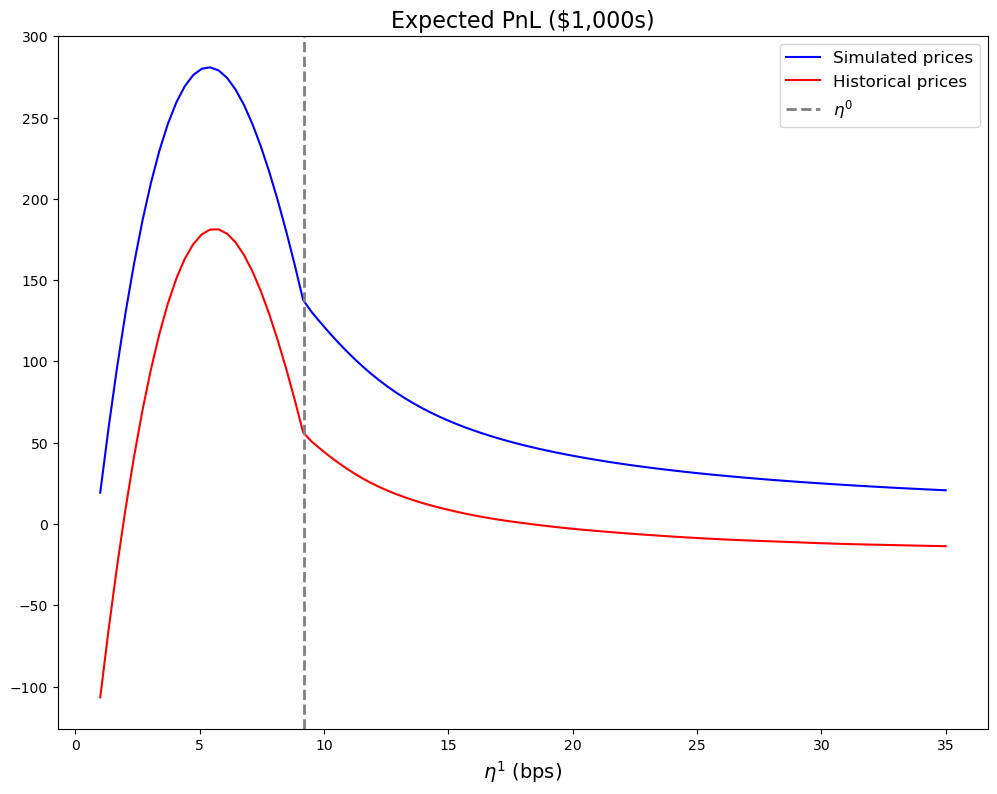

In [4]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
obj = np.empty((len(sigma_vals), len(eta1_vals)))

sigma_base = 0.026


idx_closest = np.argmin(np.abs(sigma_vals - sigma_base))
sigma_closest = sigma_vals[idx_closest]

for i, sigma in enumerate(np.array([sigma_closest])):
    outputs = sim_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        obj[i, j] = (outputs[j,0]+outputs[j,1]+outputs[j,2]+outputs[j,3]-outputs[j,4])/1000 # Compute objective


# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
obj_hist = np.empty((len(np.array([sigma_closest])), len(eta1_vals)))

for i, sigma in enumerate(np.array(['HIST'])):
    outputs = sim_outputs_hist[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        obj_hist[i, j] = (outputs[j,0]+outputs[j,1]+outputs[j,2]+outputs[j,3]-outputs[j,4])/1000 # Compute objective

# Create a meshgrid for plotting
# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111)



# Surface plot.
ax.plot(eta1_vals* 10000, obj[0,:], color='blue', label='Simulated prices')
ax.plot(eta1_vals* 10000, obj_hist[0,:], color='red', label='Historical prices')

print(eta1_vals[np.argmax(obj[0,:])])

ax.axvline(x=eta0 * 10000, color='grey', linestyle='--', linewidth=2, label=r'$\eta^0$')

# (Optionnel) ajoute une légende si tu veux l’étiquette
ax.legend(fontsize=12)


# Axes labels.
ax.set_xlabel(r'$\eta^1$ (bps)', fontsize=14)
ax.set_ylabel('')
ax.set_title('Expected PnL ($1,000s)', fontsize=16)

# Add color bar.
plt.savefig('expected_pnl_sim_br_15688.pdf',bbox_inches='tight')   
plt.show()

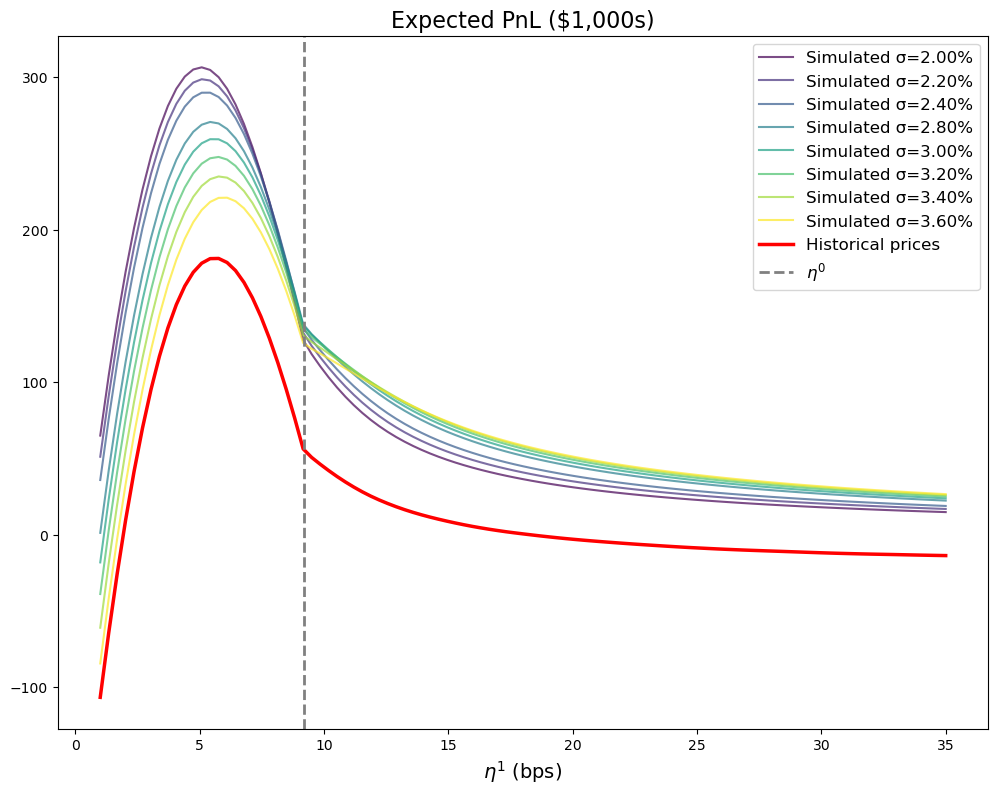

In [5]:
# Crée les indices autour de sigma_base
sigma_base = 0.026
n_sigma = 10  # nombre de valeurs autour de sigma_base
window = 0.01  # largeur de l'intervalle autour de sigma_base
sigma_grid = np.linspace(sigma_base - window, sigma_base + window, n_sigma)

# Filtrer les valeurs proches dans sigma_vals (celles effectivement simulées)
sigma_near = np.array([s for s in sigma_vals if np.min(np.abs(s - sigma_grid)) < 1e-3])

# Initialisation
obj = np.empty((len(sigma_near), len(eta1_vals)))

# Calculs pour chaque sigma proche
for i, sigma in enumerate(sigma_near):
    outputs = sim_outputs[sigma]
    for j in range(len(eta1_vals)):
        obj[i, j] = (outputs[j, 0] + outputs[j, 1] + outputs[j, 2] + outputs[j, 3] - outputs[j, 4]) / 1000

# Courbe historique
obj_hist = np.empty((len(eta1_vals),))
outputs = sim_outputs_hist['HIST']
for j in range(len(eta1_vals)):
    obj_hist[j] = (outputs[j, 0] + outputs[j, 1] + outputs[j, 2] + outputs[j, 3] - outputs[j, 4]) / 1000

# Plot
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111)

# Dégradé de couleurs
colors = cm.viridis(np.linspace(0, 1, len(sigma_near)))

# Tracer les courbes simulées
for i, sigma in enumerate(sigma_near):
    label = f'Simulated σ={sigma * 100:.2f}%'  # Affiche σ en pourcentage
    ax.plot(eta1_vals * 10000, obj[i, :], color=colors[i], alpha=0.7, label=label)

# Tracer la courbe historique
ax.plot(eta1_vals * 10000, obj_hist, color='red', linewidth=2.5, label='Historical prices')

# Ligne verticale à eta0
ax.axvline(x=eta0 * 10000, color='grey', linestyle='--', linewidth=2, label=r'$\eta^0$')

# Légende et titres
ax.legend(fontsize=12)
ax.set_xlabel(r'$\eta^1$ (bps)', fontsize=14)
ax.set_ylabel('')
ax.set_title('Expected PnL ($1,000s)', fontsize=16)

# Sauvegarde et affichage
plt.savefig(f'expected_pnl_sim_br_{round(buy_rate)}_vol.pdf', bbox_inches='tight')   
plt.show()

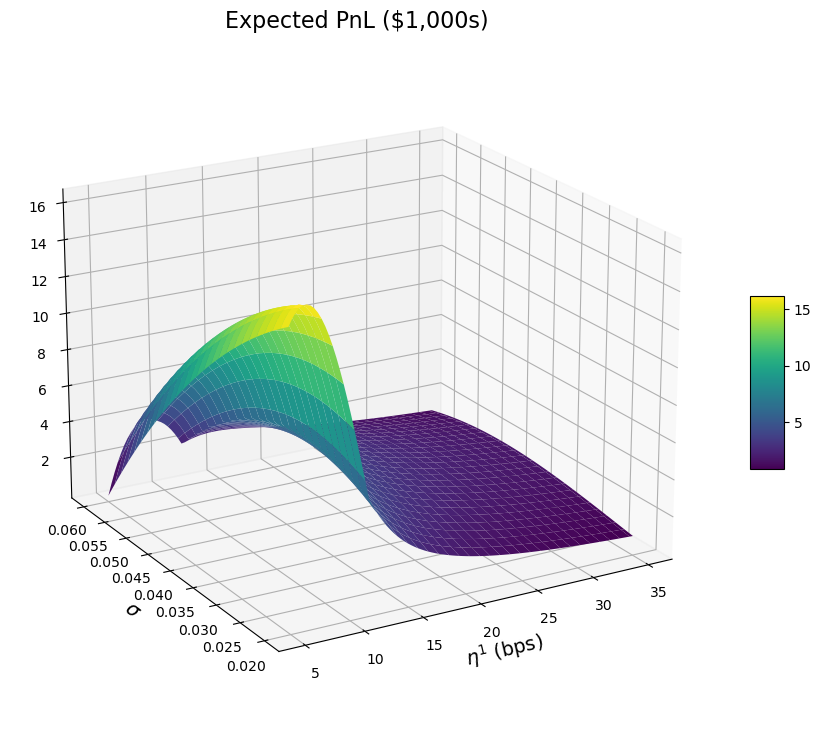

In [11]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
obj = np.empty((len(sigma_vals), len(eta1_vals)))

for i, sigma in enumerate(sigma_vals):
    outputs = sim_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        obj[i, j] = (outputs[j,0]+outputs[j,1]+outputs[j,2]+outputs[j,3]-outputs[j,4])/1000 # Compute objective

# Create a meshgrid for plotting.
ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=-120)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, obj, cmap='viridis')

# Axes labels.
ax.set_xlabel(r'$\eta^1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Expected PnL ($1,000s)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
plt.savefig('expected_pnl_25000_demand_eta0_50bps.pdf',bbox_inches='tight')   
plt.show()

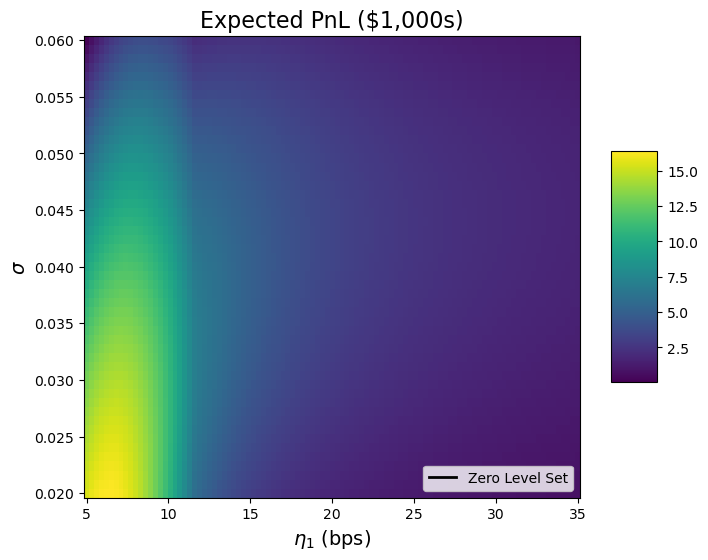

In [12]:
# Create a heatmap.
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.pcolormesh(ETA * 10000, SIGMA, obj, cmap='viridis', shading='auto')

# Overlay a black contour line at the zero level of the objective function.
contour = ax.contour(ETA * 10000, SIGMA, obj, levels=[0], colors='black', linewidths=2)

# Create a proxy for the contour line to use in the legend.
zls_line = Line2D([0], [0], color='black', lw=2, label='Zero Level Set')

# Add the legend.
ax.legend(handles=[zls_line], loc='lower right')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_title('Expected PnL ($1,000s)', fontsize=16)

# Add a colorbar.
cbar = fig.colorbar(heatmap, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('', fontsize=14)

plt.savefig('expected_pnl_level_set.pdf',bbox_inches='tight')
plt.show()

[0.02   0.0232 0.0264 0.0296 0.0328 0.036  0.0392 0.0424 0.0456 0.0488
 0.052  0.0552 0.0584]


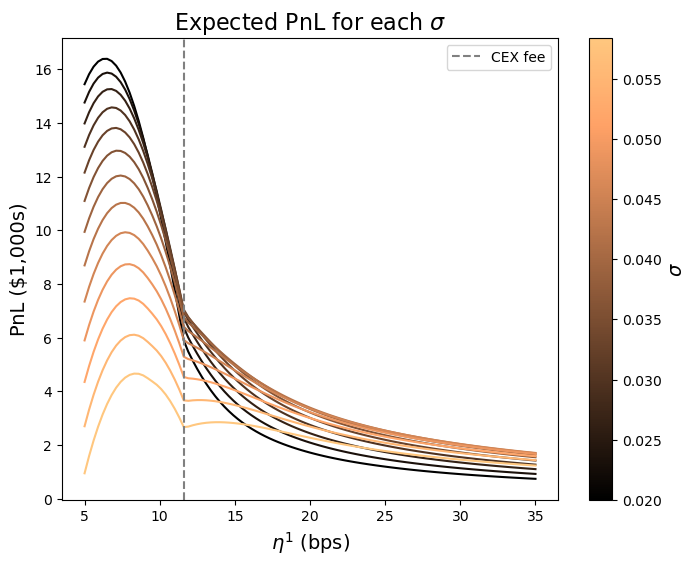

In [13]:
# Create the figure and axis.
fig, ax = plt.subplots(figsize=(8, 6))

# build a mask of the same length as sigma_vals
mask = (np.arange(len(sigma_vals)) % 4 == 0) & (sigma_vals < 0.062)

# subset the array
sub_sigma = sigma_vals[mask]
obj_sub = obj[mask,:]
print(sub_sigma)

# Create a color gradient in the values of sigma.
norm_sigma = mpl.colors.Normalize(vmin=np.min(sub_sigma), vmax=np.max(sub_sigma))
cmap = plt.get_cmap("copper")

# Plot the objective (Expected PnL) as a function of eta1 for each sigma value.
for i, sigma in enumerate(sub_sigma):
    #if i % 4 == 1 and sigma<0.06:
        # Get a color corresponding to the current sigma and plot the objective.
        color = cmap(norm_sigma(sigma))
        ax.plot(eta1_vals * 10000, obj_sub[i, :], color=color, label='')

# Add vertical line to indicate CEX fee level
plt.axvline(x=eta0 * 10000, color="grey", linestyle="--", label="CEX fee")

# Label the axes.
ax.set_xlabel(r'$\eta^1$ (bps)', fontsize=14)
ax.set_ylabel('PnL ($1,000s)', fontsize=14)
ax.set_title(r'Expected PnL for each $\sigma$', fontsize=16)
ax.legend(loc='upper right')

# Add a colorbar corresponding to the value of sigma.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_sigma)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\sigma$', fontsize=14)

plt.savefig('expected_pnl_eta1_view_subset.pdf',bbox_inches='tight')
plt.show()

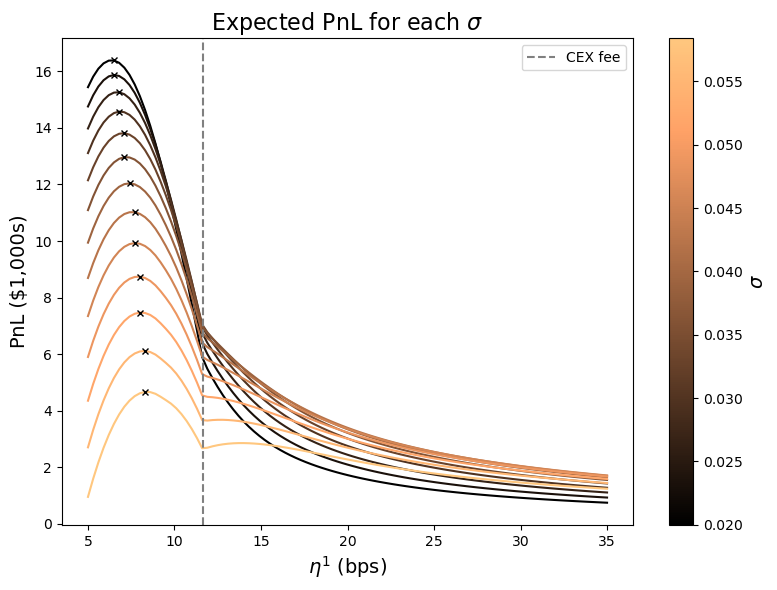

In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Create the figure and axis.
fig, ax = plt.subplots(figsize=(8, 6))

# build a mask of the same length as sigma_vals
mask = (np.arange(len(sigma_vals)) % 4 == 0) & (sigma_vals < 1.)

# subset the array
sub_sigma = sigma_vals[mask]
obj_sub    = obj[mask, :]

# Create a color gradient in the values of sigma.
norm_sigma = mpl.colors.Normalize(vmin=np.min(sub_sigma), vmax=np.max(sub_sigma))
cmap       = plt.get_cmap("copper")

# Plot each curve and mark its maximum
for i, sigma in enumerate(sub_sigma):
    x = eta1_vals * 10000        # x-axis in bps
    y = obj_sub[i, :]            # corresponding PnL

    color = cmap(norm_sigma(sigma))
    ax.plot(x, y, color=color)

    # find index of maximum y, and overplot a black "x"
    idx_max = np.argmax(y)
    ax.plot(x[idx_max], y[idx_max],
            marker='x', markersize=5, color='black')

# Add vertical line to indicate CEX fee level
ax.axvline(x=eta0 * 10000, color="grey", linestyle="--", label="CEX fee")

# Label the axes.
ax.set_xlabel(r'$\eta^1$ (bps)', fontsize=14)
ax.set_ylabel('PnL ($1,000s)', fontsize=14)
ax.set_title(r'Expected PnL for each $\sigma$', fontsize=16)

# Add a colorbar corresponding to the value of sigma.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_sigma)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\sigma$', fontsize=14)

ax.legend(loc='upper right')
fig.tight_layout()

plt.savefig('expected_pnl_eta1_view_subset_with_max.pdf', bbox_inches='tight')
plt.show()


[0.02   0.0232 0.0264 0.0296 0.0328 0.036  0.0392 0.0424 0.0456 0.0488
 0.052  0.0552 0.0584]


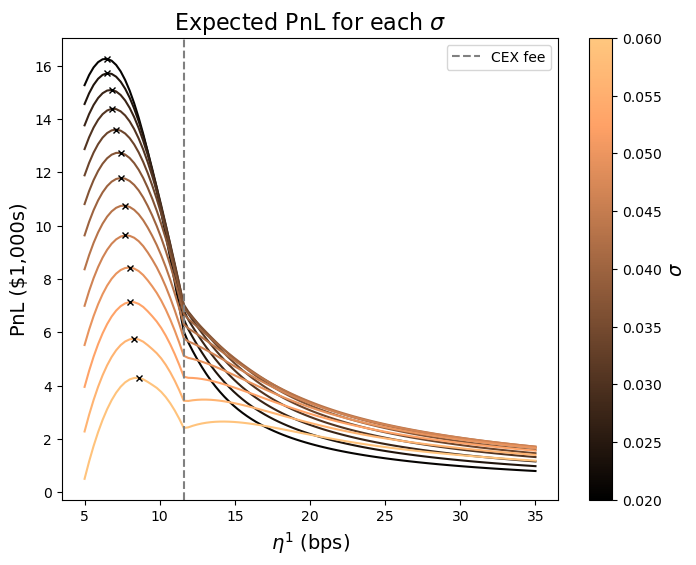

In [15]:
# Create the figure and axis.
fig, ax = plt.subplots(figsize=(8, 6))

# build a mask of the same length as sigma_vals
mask = (np.arange(len(sigma_vals)) % 4 == 0) & (sigma_vals < 0.062)

# subset the array
sub_sigma = sigma_vals[mask]
obj_sub = obj[mask,:]
print(sub_sigma)

# Create a color gradient in the values of sigma.
norm_sigma = mpl.colors.Normalize(vmin=np.min(sigma_vals), vmax=np.max(sigma_vals))
cmap = plt.get_cmap("copper")

# Plot the objective (Expected PnL) as a function of eta1 for each sigma value.
for i, sigma in enumerate(sigma_vals):
    if i % 4 == 1: #and sigma<0.06:
        # Get a color corresponding to the current sigma and plot the objective.
        color = cmap(norm_sigma(sigma))
        ax.plot(eta1_vals * 10000, obj[i, :], color=color, label='')

        x = eta1_vals * 10000        # x-axis in bps
        y = obj[i, :]            # corresponding PnL
        # find index of maximum y, and overplot a black "x"
        idx_max = np.argmax(y)
        ax.plot(x[idx_max], y[idx_max],
                marker='x', markersize=5, color='black')

# Add vertical line to indicate CEX fee level
plt.axvline(x=eta0 * 10000, color="grey", linestyle="--", label="CEX fee")

# Label the axes.
ax.set_xlabel(r'$\eta^1$ (bps)', fontsize=14)
ax.set_ylabel('PnL ($1,000s)', fontsize=14)
ax.set_title(r'Expected PnL for each $\sigma$', fontsize=16)
ax.legend(loc='upper right')

# Add a colorbar corresponding to the value of sigma.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_sigma)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\sigma$', fontsize=14)

plt.savefig('expected_pnl_eta1_view_full_with_max.pdf',bbox_inches='tight')
plt.show()

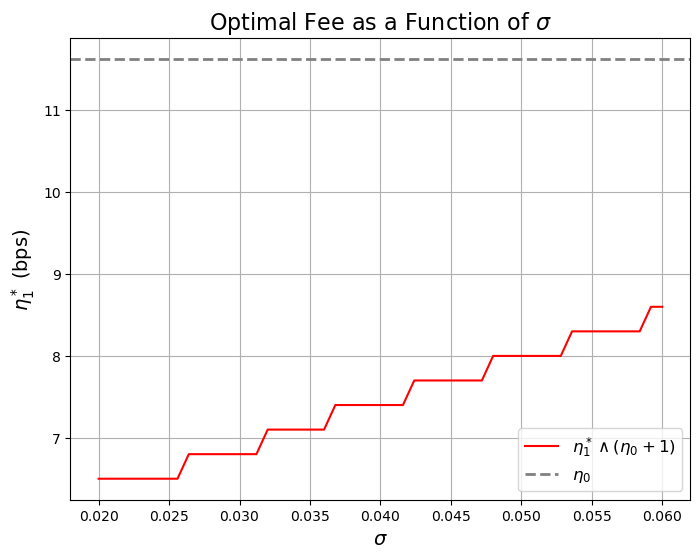

In [16]:
# Find the index of the maximum objective for each sigma (each row in obj)
optimal_indices = np.argmax(obj, axis=1)

# Map those indices to the corresponding eta1 values
optimal_eta1 = eta1_vals[optimal_indices]

# Cap the maximum eta1 to be eta0 + 0.0001 (for plotting)
optimal_eta1 = np.minimum(optimal_eta1, eta0 + 0.0001)

# Plot optimal eta1 as a function of sigma
plt.figure(figsize=(8, 6))
plt.plot(sigma_vals, optimal_eta1 * 10000, linestyle='-', color='r', label=r'$\eta_1^* \wedge (\eta_0+1)$')
# Add horizontal line for eta0 (converted to bps)
plt.axhline(y=eta0 * 10000, color='grey', linestyle='--', linewidth=2, label=r'$\eta_0$')

plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel(r'$\eta_1^*$ (bps)', fontsize=14)
plt.title(r'Optimal Fee as a Function of $\sigma$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.savefig('optimal_fee_50bps.pdf',bbox_inches='tight')
plt.show()


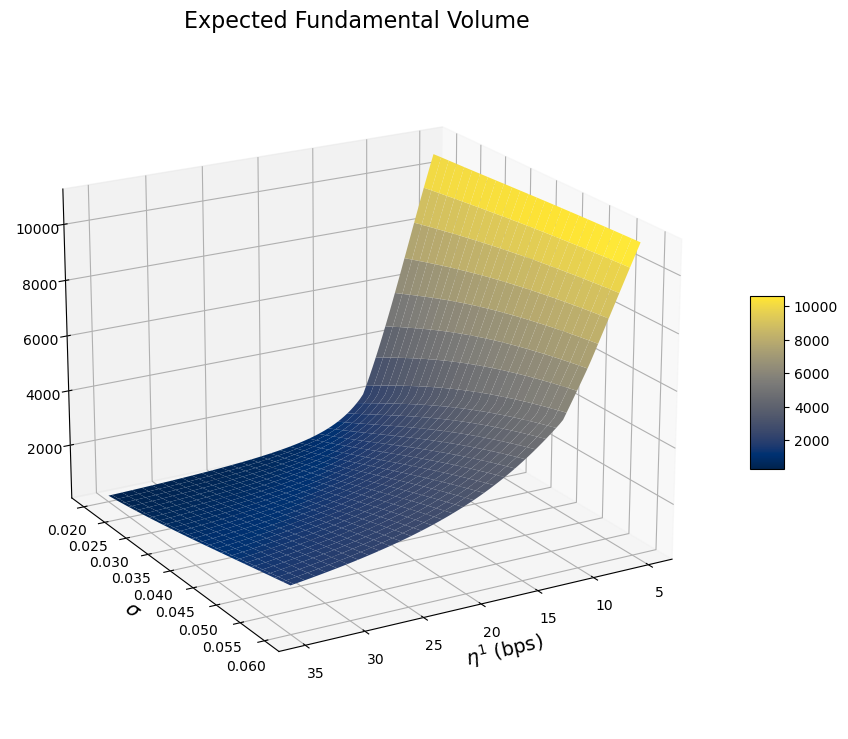

In [17]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
sys_vol = np.empty((len(sigma_vals), len(eta1_vals)))

for i, sigma in enumerate(sigma_vals):
    outputs = sim_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        sys_vol[i, j] = (outputs[j,5]+abs(outputs[j,6])) # Compute objective

# Create a meshgrid for plotting.
ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=60)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, sys_vol, cmap='cividis')

# Axes labels.
ax.set_xlabel(r'$\eta^1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Expected Fundamental Volume', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)

plt.savefig('expected_sys_volume2.pdf',bbox_inches='tight')
plt.show()

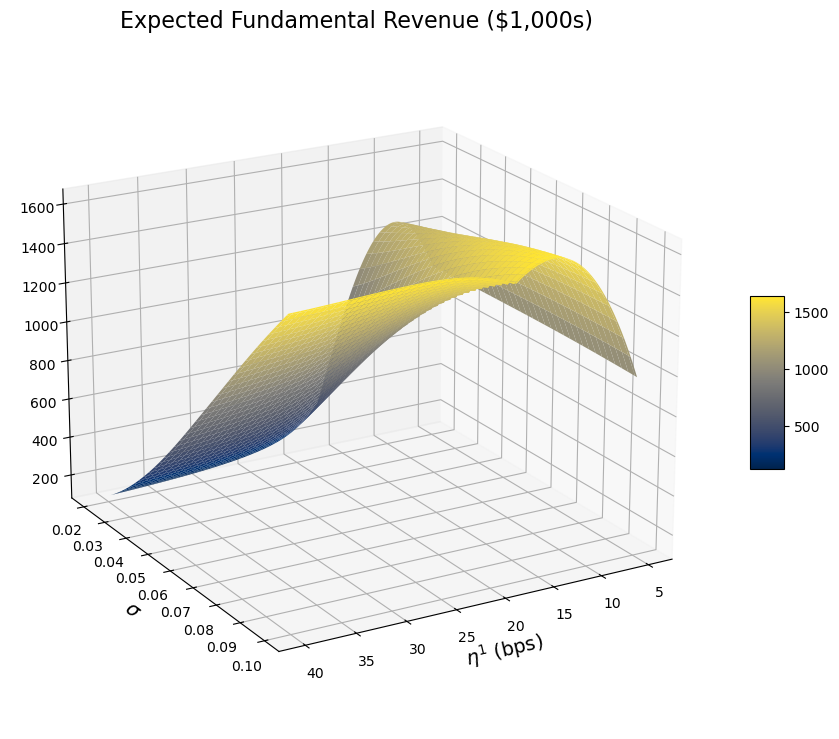

In [11]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
sys_rev = np.empty((len(sigma_vals), len(eta1_vals)))

for i, sigma in enumerate(sigma_vals):
    outputs = sim_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        sys_rev[i, j] = (outputs[j,0]+outputs[j,1])/1000 # Compute objective

# Create a meshgrid for plotting.
ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=60)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, sys_rev, cmap='cividis')

# Axes labels.
ax.set_xlabel(r'$\eta^1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Expected Fundamental Revenue ($1,000s)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)

plt.savefig('expected_sys_revenue2.pdf',bbox_inches='tight')
plt.show()

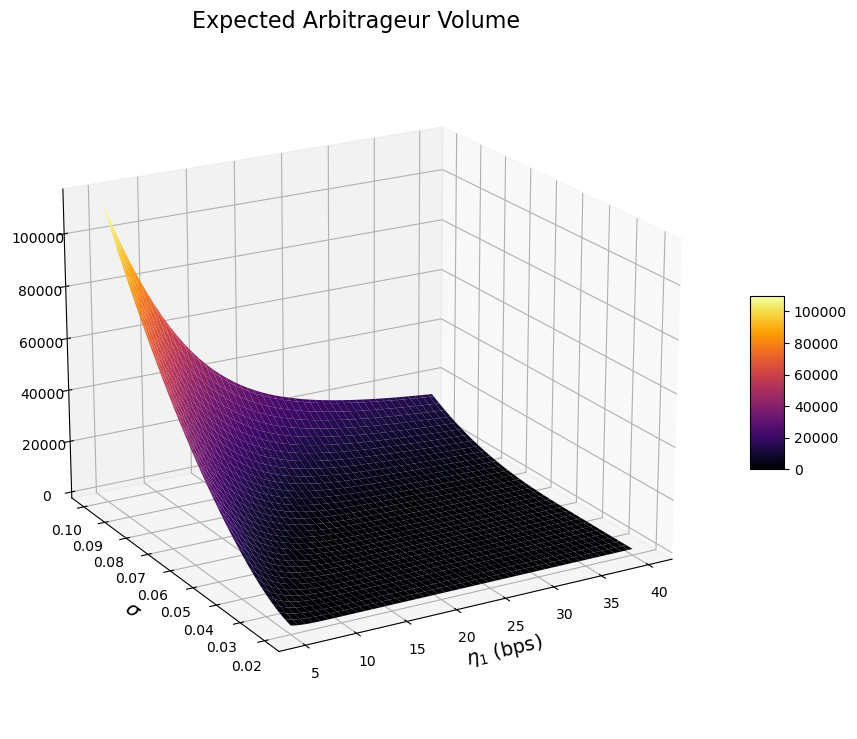

In [12]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
arb_vol = np.empty((len(sigma_vals), len(eta1_vals)))

for i, sigma in enumerate(sigma_vals):
    outputs = sim_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        arb_vol[i, j] = abs(outputs[j,7]) # Compute objective

# Create a meshgrid for plotting.
ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=-120)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, arb_vol, cmap='inferno')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Expected Arbitrageur Volume', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)

plt.savefig('expected_arb_volume.pdf',bbox_inches='tight')
plt.show()

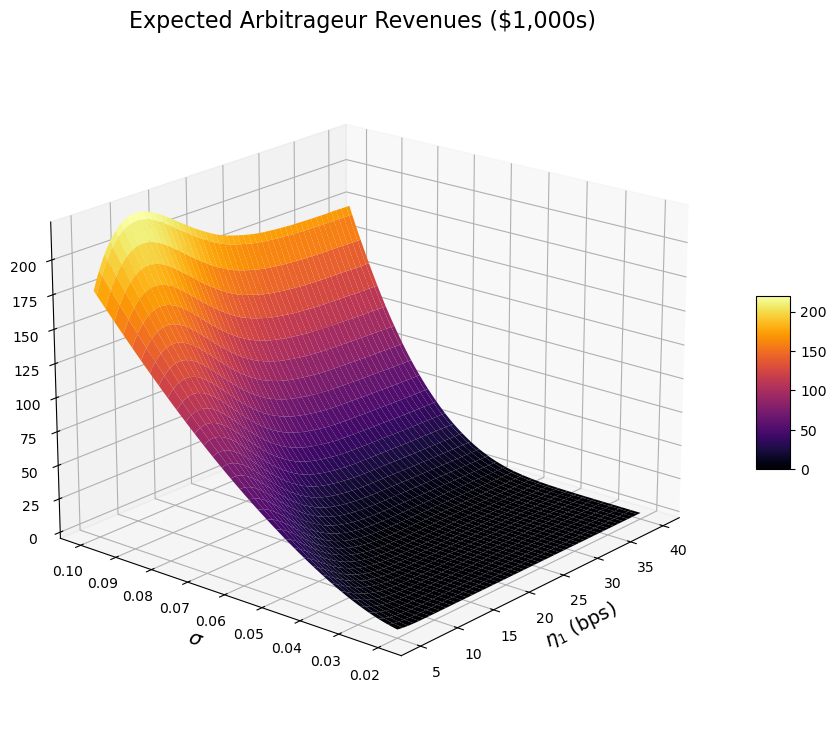

In [13]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
arb_rev = np.empty((len(sigma_vals), len(eta1_vals)))

for i, sigma in enumerate(sigma_vals):
    outputs = sim_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        arb_rev[i, j] = outputs[j,2]/1000 # Compute objective

# Create a meshgrid for plotting.
ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=-140)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, arb_rev, cmap='inferno')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Expected Arbitrageur Revenues ($1,000s)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)

plt.savefig('expected_arb_revenue.pdf',bbox_inches='tight')
plt.show()

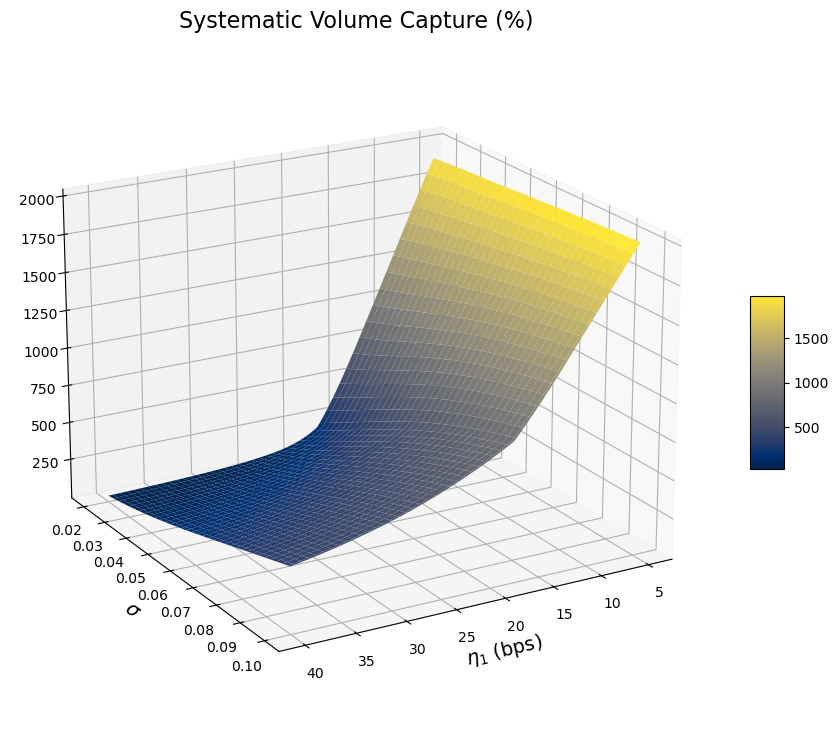

In [14]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
sys_vol = np.empty((len(sigma_vals), len(eta1_vals)))

for i, sigma in enumerate(sigma_vals):
    outputs = sim_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        sys_vol[i, j] = (outputs[j,5]+abs(outputs[j,6])) # Compute objective

# Create a meshgrid for plotting.
ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=60)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, 100 * sys_vol / (buy_rate + sell_rate), cmap='cividis')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Systematic Volume Capture (%)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
plt.savefig('expected_sys_volume_capture2.pdf',bbox_inches='tight')

plt.show()

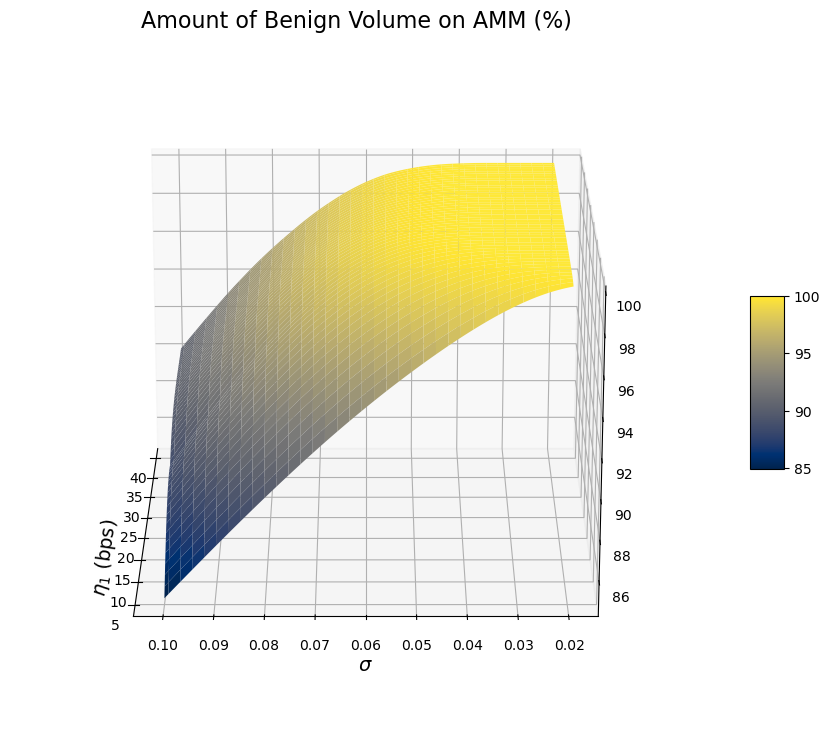

In [15]:
# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=180)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, 100 * sys_vol/(sys_vol + arb_vol), cmap='cividis')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Amount of Benign Volume on AMM (%)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)

plt.savefig('expected_benign_vol_percent.pdf',bbox_inches='tight')
plt.show()

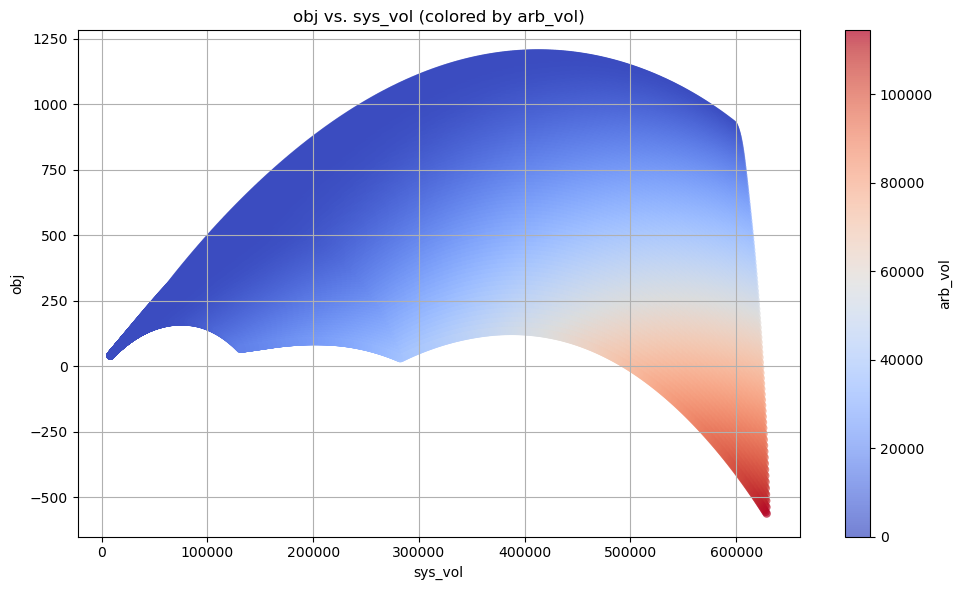

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# flatten your arrays
a = arb_vol.flatten()   # will drive the color
s = sys_vol.flatten()   # x‐axis
y = obj.flatten()       # y‐axis

# make the scatter
plt.figure(figsize=(10,6))
sc = plt.scatter(
    s, y,
    c=a,                # color by arb_vol
    cmap='coolwarm',    # blue at low, red at high
    alpha=0.7,
    edgecolors='none'
)

# add a colorbar so you know which arb_vol maps to which color
cb = plt.colorbar(sc)
cb.set_label('arb_vol')

# labels & title
plt.xlabel('sys_vol')
plt.ylabel('obj')
plt.title('obj vs. sys_vol (colored by arb_vol)')
plt.grid(True)
plt.tight_layout()
plt.show()


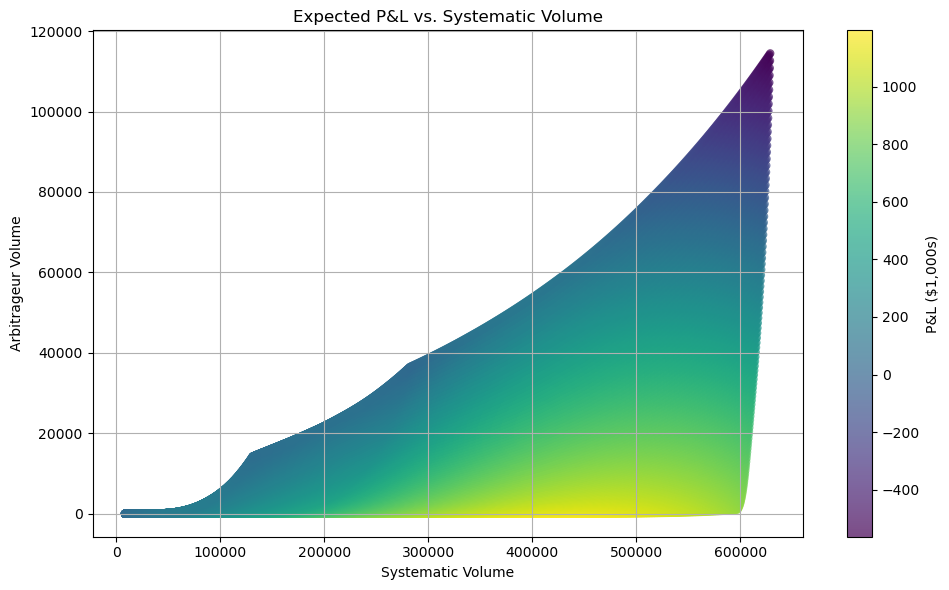

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# flatten your arrays
a = arb_vol.flatten()   # will drive the color
s = sys_vol.flatten()   # x‐axis
y = obj.flatten()       # y‐axis

# make the scatter
plt.figure(figsize=(10,6))
sc = plt.scatter(
    s, a,
    c= y,                # color by arb_vol
    cmap='viridis',    # blue at low, red at high
    alpha=0.7,
    edgecolors='none'
)

# add a colorbar so you know which arb_vol maps to which color
cb = plt.colorbar(sc)
cb.set_label('P&L ($1,000s)')

# labels & title
plt.xlabel('Systematic Volume')
plt.ylabel('Arbitrageur Volume')
plt.title('Expected P&L vs. Systematic Volume')
plt.grid(True)
plt.tight_layout()
plt.savefig('expected_pnl_vs_vol_type.pdf',bbox_inches='tight')
plt.show()


In [18]:
import statsmodels.api as sm

total_vol = (arb_vol.flatten()+sys_vol.flatten())

frac_ben = sys_vol.flatten()/np.maximum(total_vol,1)
#frac_ben[(frac_ben==0)]

print(np.shape(sys_vol))
# flatten
y = obj.flatten()
X = np.column_stack([
    #Sigma_mat.flatten(),
    sys_vol.flatten(),
    arb_vol.flatten(),
    #frac_ben.flatten()
    #arb_vol.flatten() * sys_vol.flatten(), 
    #arb_vol.flatten() ** 2,
    #sys_vol.flatten() ** 2
])

# add intercept
X = sm.add_constant(X)  # column of 1s + your two predictors

# fit OLS
model = sm.OLS(y, X).fit()

# view results
print(model.summary())


(101, 1001)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                 3.924e+05
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:09:24   Log-Likelihood:            -6.0970e+05
No. Observations:              101101   AIC:                         1.219e+06
Df Residuals:                  101098   BIC:                         1.219e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.1354      0.518    170.

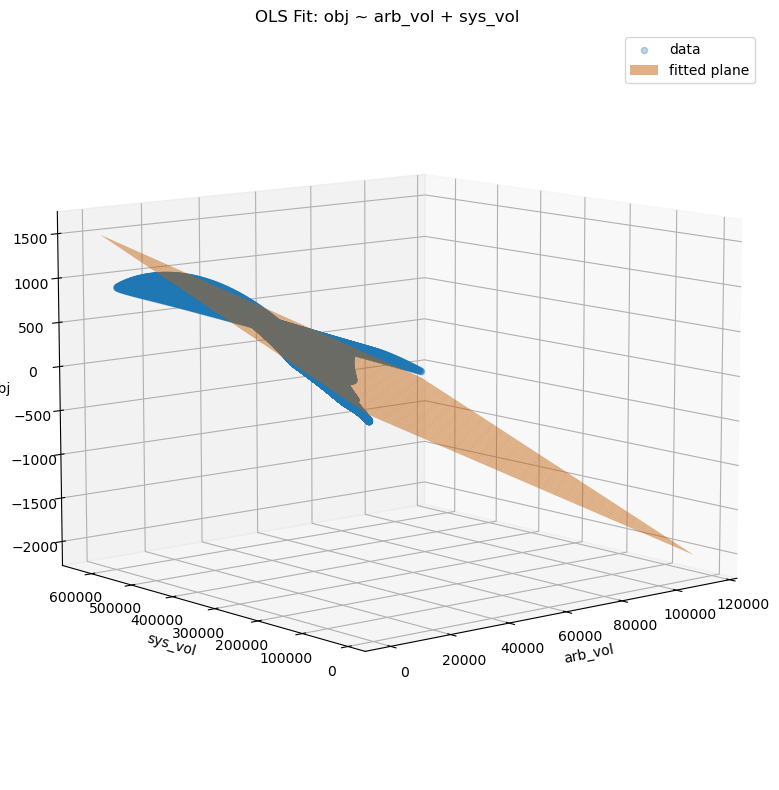

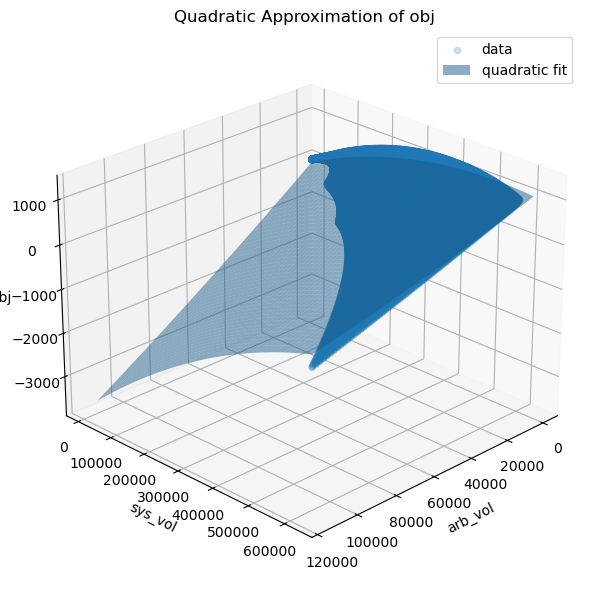

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 1.629e+05
Date:                Fri, 20 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:09:30   Log-Likelihood:            -5.7585e+05
No. Observations:              101101   AIC:                         1.152e+06
Df Residuals:                  101090   BIC:                         1.152e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.523e-16   3.55e-19    429.620      0.0

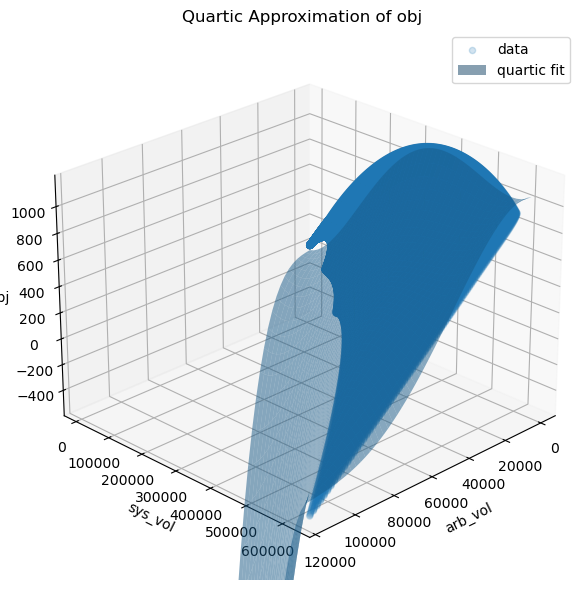

In [19]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1) Fit the model (again) ---
# flatten your data
y = obj.flatten()
X = np.column_stack([arb_vol.flatten(), sys_vol.flatten()])
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# extract parameter estimates
const, beta_arb, beta_sys = model.params

# --- 2) Build a grid over the arb_vol / sys_vol domain ---
# pick a modest mesh resolution
arb_lin = np.linspace(arb_vol.min(), arb_vol.max(), 30)
sys_lin = np.linspace(sys_vol.min(), sys_vol.max(), 30)
A_grid, S_grid = np.meshgrid(arb_lin, sys_lin)

# compute predicted obj on that grid
Z_grid = const + beta_arb * A_grid + beta_sys * S_grid

# --- 3) Plot data + fitted plane ---
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# scatter the raw points
ax.scatter(arb_vol.flatten(), sys_vol.flatten(), obj.flatten(), 
           alpha=0.3, label='data')

# plot the regression surface
ax.plot_surface(A_grid, S_grid, Z_grid, 
                rstride=1, cstride=1, 
                alpha=0.5, color='C1', edgecolor='none',
                label='fitted plane')

ax.set_xlabel('arb_vol')
ax.set_ylabel('sys_vol')
ax.set_zlabel('obj')
ax.set_title('OLS Fit: obj ~ arb_vol + sys_vol')

# after you’ve created ax = fig.add_subplot(..., projection='3d')

# set elevation & azimuth in degrees
ax.view_init(elev=10, azim=230)

# then show or save
#plt.show()
# or
# fig.savefig('rotated_view.png', dpi=150)


plt.legend()
plt.tight_layout()
plt.show()


#############################

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1) (Re)fit your quadratic model if you haven't already ---
y = obj.flatten()
a = arb_vol.flatten()
s = sys_vol.flatten()

X = np.column_stack([
    s,            # sys_vol
    a,            # arb_vol
    a * s,        # interaction
    a**2,         # arb^2
    s**2          # sys^2
])
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# pull out the fitted coefficients
const, b_s, b_a, b_int, b_a2, b_s2 = model.params

# --- 2) build a grid in (arb, sys) ---
n_grid = 50
arb_lin = np.linspace(arb_vol.min(), arb_vol.max(), n_grid)
sys_lin = np.linspace(sys_vol.min(), sys_vol.max(), n_grid)
A_grid, S_grid = np.meshgrid(arb_lin, sys_lin)

# evaluate the quadratic form on the grid
Z_grid = (const
          + b_s * S_grid
          + b_a * A_grid
          + b_int * A_grid * S_grid
          + b_a2 * A_grid**2
          + b_s2 * S_grid**2)

# --- 3) plot raw data + fitted quadratic surface ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# raw scatter
ax.scatter(a, s, y, alpha=0.2, label='data')

# fitted quadratic surface
ax.plot_surface(A_grid, S_grid, Z_grid,
                rstride=1, cstride=1,
                alpha=0.5, edgecolor='none',
                label='quadratic fit')

ax.set_xlabel('arb_vol')
ax.set_ylabel('sys_vol')
ax.set_zlabel('obj')
ax.set_title('Quadratic Approximation of obj')

# optional: adjust view angle
ax.view_init(elev=25, azim=45)

plt.legend()
plt.tight_layout()
plt.show()

####################



import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures

# --- 1) Prepare your data ---
y = obj.flatten()                   # response
a = arb_vol.flatten()               # arb_vol
s = sys_vol.flatten()               # sys_vol
X_raw = np.vstack([a, s]).T         # shape (m*n, 2)

# --- 2) Generate all monomials up to degree 4 ---
poly = PolynomialFeatures(degree=4, include_bias=True)
X_poly = poly.fit_transform(X_raw)
# X_poly columns correspond to: [1, a, s, a^2, a s, s^2, a^3, a^2 s, a s^2, s^3, ..., a^4, a^3 s, a^2 s^2, a s^3, s^4]

# --- 3) Fit the quartic OLS ---
model = sm.OLS(y, X_poly).fit()
print(model.summary())  # inspect coefficients, R², etc.

# --- 4) Build a grid for plotting the fitted surface ---
n_grid = 50
arb_lin = np.linspace(arb_vol.min(), arb_vol.max(), n_grid)
sys_lin = np.linspace(sys_vol.min(), sys_vol.max(), n_grid)
A_grid, S_grid = np.meshgrid(arb_lin, sys_lin)
grid_points = np.vstack([A_grid.ravel(), S_grid.ravel()]).T  # shape (n_grid^2, 2)

# transform grid into quartic features
Z_poly = poly.transform(grid_points)  # shape (n_grid^2, n_features)

# predict on the grid
Z_grid = model.predict(Z_poly).reshape(n_grid, n_grid)

# --- 5) Plot raw data + quartic‐fit surface ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# raw scatter
ax.scatter(a, s, y, alpha=0.2, label='data')

# quartic surface
ax.plot_surface(A_grid, S_grid, Z_grid,
                rstride=1, cstride=1,
                alpha=0.5, edgecolor='none',
                label='quartic fit')

q = obj.flatten()
# restrict z‐axis to the data’s range
ax.set_zlim(q.min(), q.max())

ax.set_xlabel('arb_vol')
ax.set_ylabel('sys_vol')
ax.set_zlabel('obj')
ax.set_title('Quartic Approximation of obj')

# set a nice viewpoint
ax.view_init(elev=25, azim=45)

plt.legend()
plt.tight_layout()
plt.show()


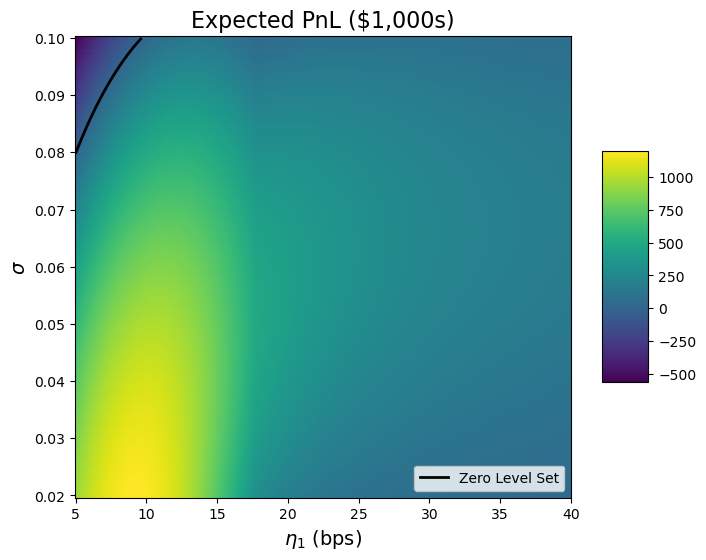

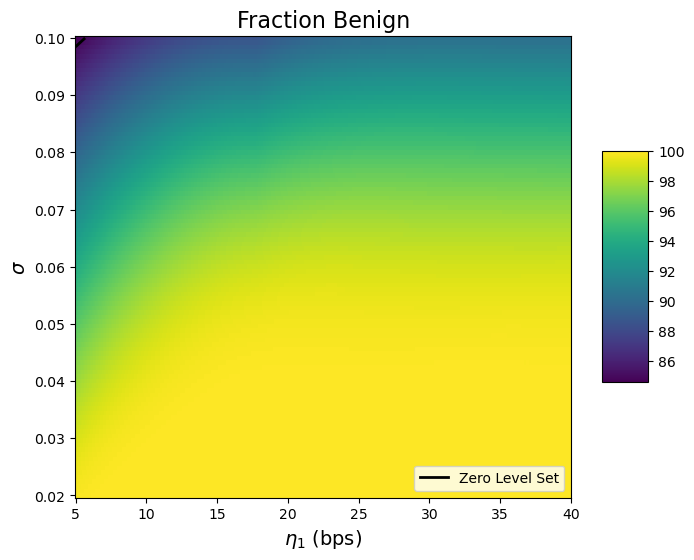

In [20]:
# Create a heatmap.
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.pcolormesh(ETA * 10000, SIGMA, obj, cmap='viridis', shading='auto')

# Overlay a black contour line at the zero level of the objective function.
contour = ax.contour(ETA * 10000, SIGMA, obj, levels=[0], colors='black', linewidths=2)

# Create a proxy for the contour line to use in the legend.
zls_line = Line2D([0], [0], color='black', lw=2, label='Zero Level Set')

# Add the legend.
ax.legend(handles=[zls_line], loc='lower right')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_title('Expected PnL ($1,000s)', fontsize=16)

# Add a colorbar.
cbar = fig.colorbar(heatmap, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('', fontsize=14)

plt.show()

# Create a heatmap.
frac_benign = 100 * sys_vol / (sys_vol + arb_vol)
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.pcolormesh(ETA * 10000, SIGMA, frac_benign, cmap='viridis', shading='auto')

# Overlay a black contour line at the zero level of the objective function.
contour = ax.contour(ETA * 10000, SIGMA, frac_benign, levels=[85], colors='black', linewidths=2)

# Create a proxy for the contour line to use in the legend.
zls_line = Line2D([0], [0], color='black', lw=2, label='Zero Level Set')

# Add the legend.
ax.legend(handles=[zls_line], loc='lower right')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_title('Fraction Benign', fontsize=16)

# Add a colorbar.
cbar = fig.colorbar(heatmap, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('', fontsize=14)

plt.show()

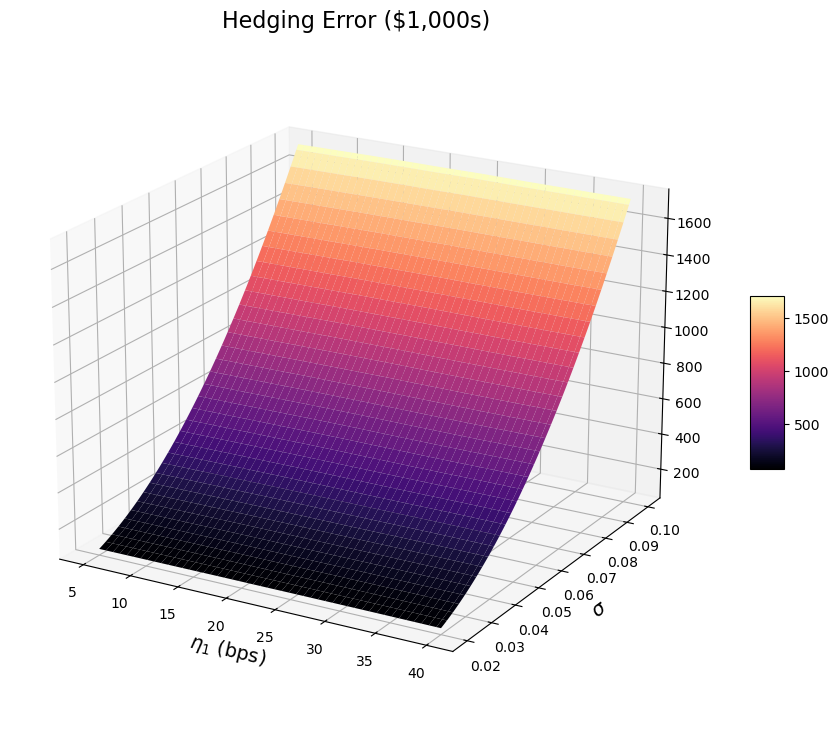

[631.16991862 631.1811758  631.19218137 ... 635.49636242 635.49426094
 635.4920675 ]


In [21]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
hedge_err = np.empty((len(sigma_vals), len(eta1_vals)))

for i, sigma in enumerate(sigma_vals):
    outputs = sim_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        hedge_err[i, j] = abs(outputs[j,3]-outputs[j,4])/1000 # Compute objective

# Create a meshgrid for plotting.
ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=-60)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, hedge_err, cmap='magma')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Hedging Error ($1,000s)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
plt.show()

print(hedge_err[50,:])

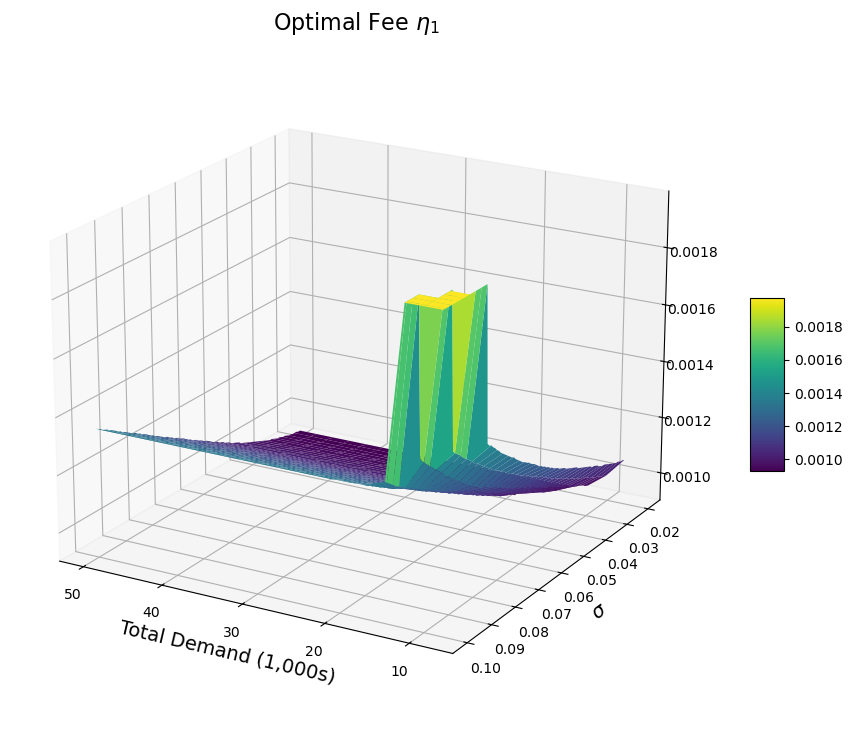

In [22]:
# Simulation Parameters 
mu = 0.0         # Mean of CEX price shock

# Set of AMM Fee values to test
eta1_vals = np.linspace(0.0005, 0.004, 1001)

# Set of sigma values for simulation
sigma_vals = np.linspace(0.02, 0.1, 101)

eta0 = 0.001774 #0.001166 # CEX proportional cost


# List of different demand values (that have simulation files)
demand_rate = np.linspace(8000., 50000., 20)

# First, determine global z-axis limits by scanning all files.
opt_fee_val = np.empty((len(sigma_vals), len(demand_rate)))
for m, dr in enumerate(demand_rate):
    filename = f"all_outputs_eta0_{eta0}_mu_{mu}_buy_{round(dr)}_sell_{round(dr)}.pkl"
    with open(filename, "rb") as f:
        sim_outputs = pickle.load(f)
    obj = np.empty((len(sigma_vals), len(eta1_vals)))
    for i, sigma in enumerate(sigma_vals):
        outputs = sim_outputs[sigma]
        for j in range(len(eta1_vals)):
            obj[i, j] = (outputs[j, 0] + outputs[j, 1] + outputs[j, 2] +
                         outputs[j, 3] - outputs[j, 4]) / 1000  # Compute objective
    # Find the index of the maximum objective for each sigma (each row in obj)
    optimal_indices = np.argmax(obj, axis=1)
    # Map those indices to the corresponding eta1 values
    optimal_eta1 = eta1_vals[optimal_indices]
    opt_fee_val[:, m] = optimal_eta1

# Create a meshgrid for plotting.
DEMAND, SIGMA = np.meshgrid(demand_rate, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=120)

# Surface plot.
surface = ax.plot_surface(DEMAND / 1000, SIGMA, np.minimum(opt_fee_val,eta0+0.0002), cmap='viridis')

# Axes labels.
ax.set_xlabel(r'Total Demand (1,000s)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title(r'Optimal Fee $\eta_1$', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
plt.show()
            

[ 8000.         10210.52631579 12421.05263158 14631.57894737
 16842.10526316 19052.63157895 21263.15789474 23473.68421053
 25684.21052632 27894.73684211 30105.26315789 32315.78947368
 34526.31578947 36736.84210526 38947.36842105 41157.89473684
 43368.42105263 45578.94736842 47789.47368421 50000.        ]


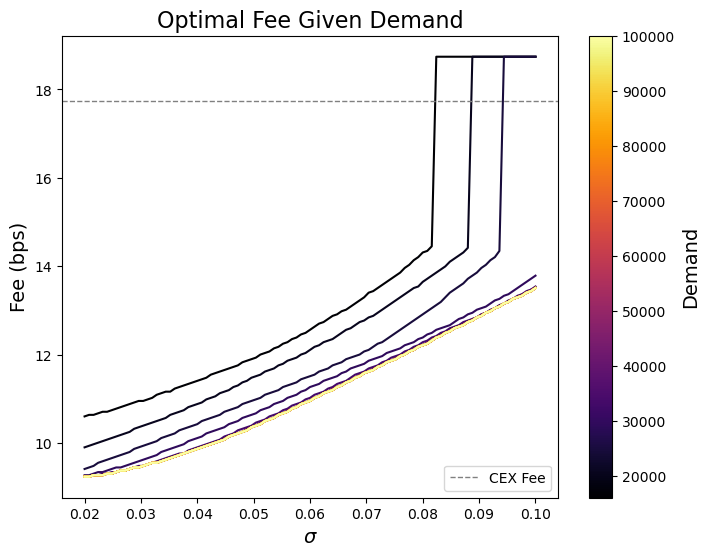

In [23]:



# build a mask of the same length as sigma_vals
mask = (demand_rate < 100001)

# subset the array
sub_demand_rate = demand_rate[mask]
opt_fee_sub = opt_fee_val[:,mask]
print(sub_demand_rate)

# Create a color gradient in the values of demand.
norm_demand = mpl.colors.Normalize(vmin=2 * np.min(sub_demand_rate), vmax=2 * np.max(sub_demand_rate))
cmap = plt.get_cmap("inferno")


# Create the figure and axis.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the objective (Expected PnL) as a function of eta1 for each sigma value.
for m, dr in enumerate(sub_demand_rate):
    #if dr<10000:
        # Get a color corresponding to the current sigma and plot the objective.
        color = cmap(norm_demand(2 * dr))
        ax.plot(sigma_vals, np.minimum(opt_fee_sub[:, m], eta0+0.0001)*10000, color=color, label='')

# Label the axes.
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.set_ylabel('Fee (bps)', fontsize=14)
ax.set_title(r'Optimal Fee Given Demand', fontsize=16)
# Add a dashed horizontal grey line at 50 bps with legend label
ax.axhline(y=eta0*10000, color='grey', linestyle='--', linewidth=1, label='CEX Fee')

# Place legend in bottom right
ax.legend(loc='lower right')

# Add a colorbar corresponding to the value of sigma.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_demand)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Demand', fontsize=14)
plt.savefig('optimal_fee_given_demand_subset.pdf',bbox_inches='tight')

plt.show()

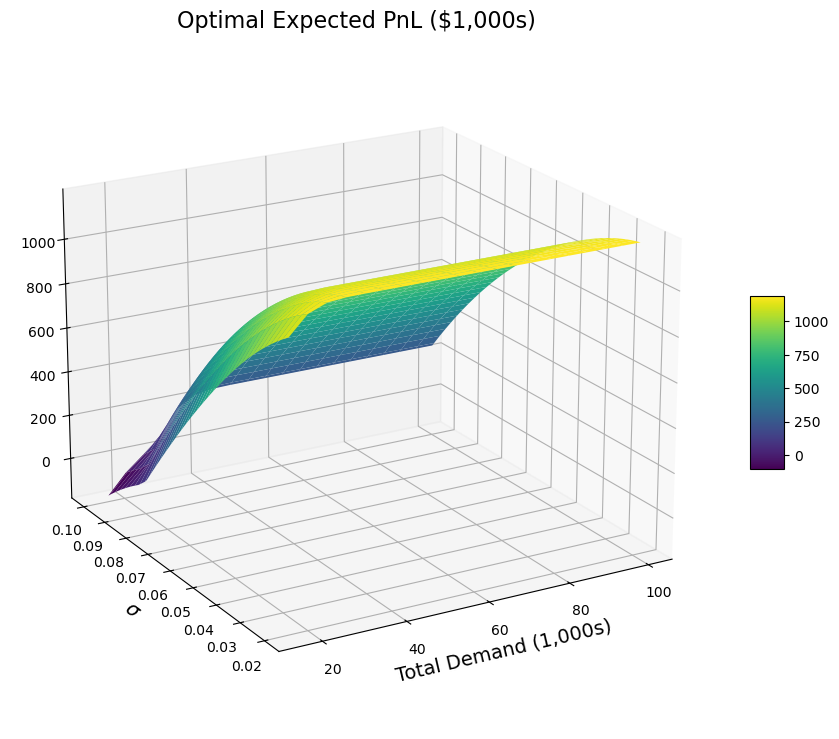

In [24]:


# First, determine global z-axis limits by scanning all files.
opt_val = np.empty((len(sigma_vals), len(demand_rate)))
for m, dr in enumerate(demand_rate):
    filename = f"all_outputs_eta0_{eta0}_mu_{mu}_buy_{round(dr)}_sell_{round(dr)}.pkl"
    with open(filename, "rb") as f:
        sim_outputs = pickle.load(f)
    obj = np.empty((len(sigma_vals), len(eta1_vals)))
    for i, sigma in enumerate(sigma_vals):
        outputs = sim_outputs[sigma]
        for j in range(len(eta1_vals)):
            obj[i, j] = (outputs[j, 0] + outputs[j, 1] + outputs[j, 2] +
                         outputs[j, 3] - outputs[j, 4]) / 1000  # Compute objective
    # Find the index of the maximum objective for each sigma (each row in obj)
    opt_val[:, m] = np.max(obj, axis=1)

# Create a meshgrid for plotting.
DEMAND, SIGMA = np.meshgrid(2 * demand_rate, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=-120)

# Surface plot.
surface = ax.plot_surface(DEMAND / 1000, SIGMA, opt_val, cmap='viridis')

# Axes labels.
ax.set_xlabel(r'Total Demand (1,000s)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title(r'Optimal Expected PnL ($1,000s)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
plt.savefig('expected_optimal_pnl2.pdf',bbox_inches='tight')
plt.show()
            

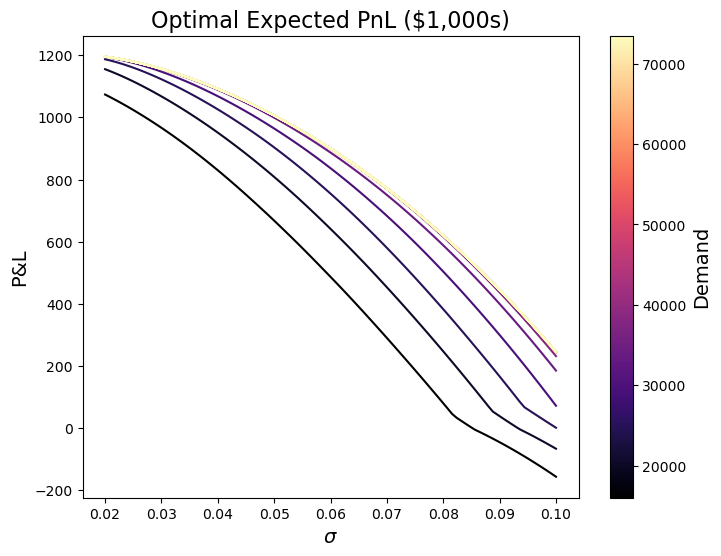

In [26]:
# Create a color gradient in the values of demand.
norm_demand = mpl.colors.Normalize(vmin=2 * np.min(demand_rate[:14]), vmax=2 * np.max(demand_rate[:14]))
cmap = plt.get_cmap("magma")

# Create the figure and axis.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the objective (Expected PnL) as a function of eta1 for each sigma value.
for m, dr in enumerate(demand_rate):
    if dr <= 100000:
        # Get a color corresponding to the current sigma and plot the objective.
        color = cmap(norm_demand(2 * dr))
        ax.plot(sigma_vals, opt_val[:, m], color=color, label='')

# Label the axes.
ax.set_xlabel(r'$\sigma$', fontsize=14)
ax.set_ylabel('P&L', fontsize=14)
ax.set_title(r'Optimal Expected PnL ($1,000s)', fontsize=16)

# Add a colorbar corresponding to the value of sigma.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_demand)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Demand', fontsize=14)
plt.savefig('expected_optimal_pnl_sigma_view.pdf',bbox_inches='tight')
plt.show()

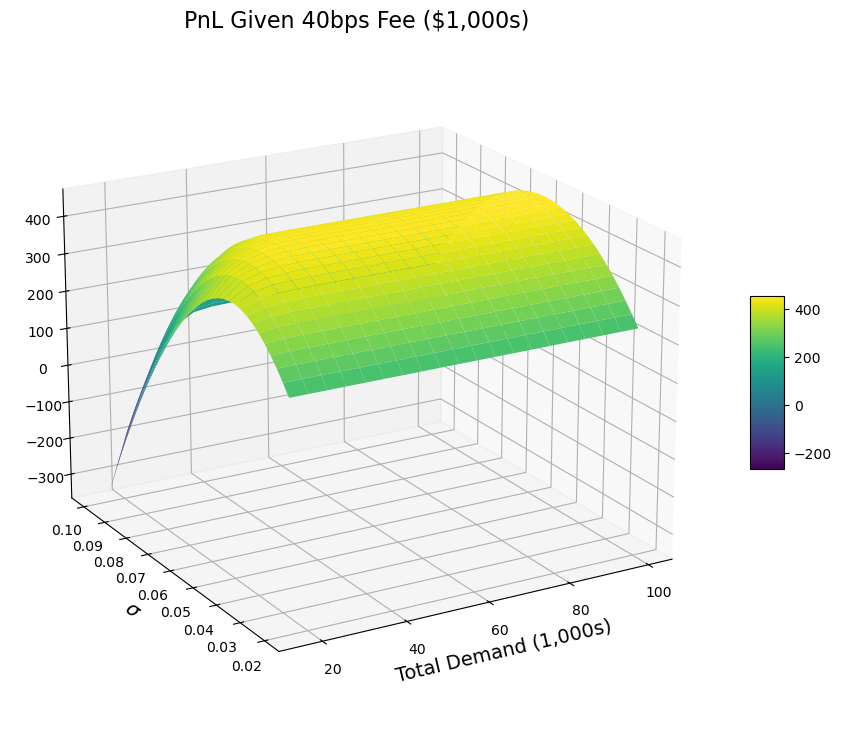

In [27]:


# First, determine global z-axis limits by scanning all files.
pnl_val = np.empty((len(sigma_vals), len(demand_rate)))
for m, dr in enumerate(demand_rate):
    filename = f"all_outputs_eta0_{eta0}_mu_{mu}_buy_{round(dr)}_sell_{round(dr)}.pkl"
    with open(filename, "rb") as f:
        sim_outputs = pickle.load(f)
    obj = np.empty((len(sigma_vals), len(eta1_vals)))
    for i, sigma in enumerate(sigma_vals):
        outputs = sim_outputs[sigma]
        for j in range(len(eta1_vals)):
            obj[i, j] = (outputs[j, 0] + outputs[j, 1] + outputs[j, 2] +
                         outputs[j, 3] - outputs[j, 4]) / 1000  # Compute objective
    # Find the index of the maximum objective for each sigma (each row in obj)
    pnl_val[:, m] = obj[:, 400]
 
# Create a meshgrid for plotting.
DEMAND, SIGMA = np.meshgrid(2 * demand_rate, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=-120)

# Surface plot.
surface = ax.plot_surface(DEMAND / 1000, SIGMA, pnl_val, cmap='viridis')

# Axes labels.
ax.set_xlabel(r'Total Demand (1,000s)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title(r'PnL Given 40bps Fee ($1,000s)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
plt.savefig('pnl_fixed_eta1_40bps_given_demand_vol.pdf',bbox_inches='tight')
plt.show()
            

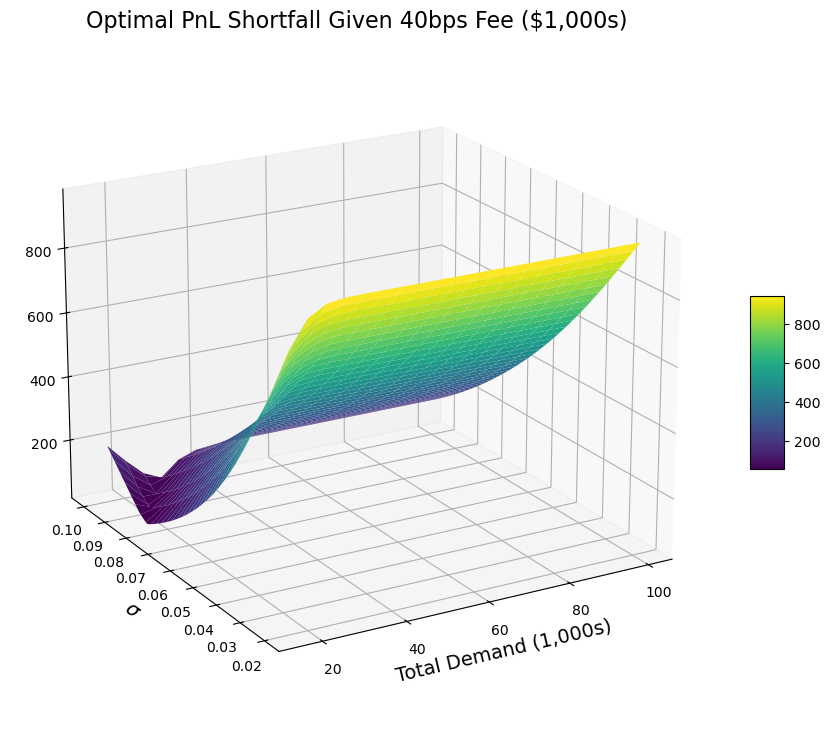

In [28]:


# First, determine global z-axis limits by scanning all files.
pnl_val = np.empty((len(sigma_vals), len(demand_rate)))
for m, dr in enumerate(demand_rate):
    filename = f"all_outputs_eta0_{eta0}_mu_{mu}_buy_{round(dr)}_sell_{round(dr)}.pkl"
    with open(filename, "rb") as f:
        sim_outputs = pickle.load(f)
    obj = np.empty((len(sigma_vals), len(eta1_vals)))
    for i, sigma in enumerate(sigma_vals):
        outputs = sim_outputs[sigma]
        for j in range(len(eta1_vals)):
            obj[i, j] = (outputs[j, 0] + outputs[j, 1] + outputs[j, 2] +
                         outputs[j, 3] - outputs[j, 4]) / 1000  # Compute objective
    # Find the index of the maximum objective for each sigma (each row in obj)
    pnl_val[:, m] = obj[:, 400]
 
# Create a meshgrid for plotting.
DEMAND, SIGMA = np.meshgrid(2 * demand_rate, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=-120)

# Surface plot.
surface = ax.plot_surface(DEMAND / 1000, SIGMA, opt_val-pnl_val, cmap='viridis')

# Axes labels.
ax.set_xlabel(r'Total Demand (1,000s)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title(r'Optimal PnL Shortfall Given 40bps Fee ($1,000s)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
plt.savefig('opt_pnl_shortfall_fixed_eta1.pdf',bbox_inches='tight')
plt.show()
            